In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

In [ ]:
!wget https://tlk.s3.yandex.net/course/shad_cv_project_22/dataset_students.zip
!unzip dataset_students.zip


--2022-10-10 15:41:36--  https://tlk.s3.yandex.net/course/shad_cv_project_22/dataset_students.zip
Resolving tlk.s3.yandex.net (tlk.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to tlk.s3.yandex.net (tlk.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 420347812 (401M) [application/zip]
Saving to: ‘dataset_students.zip.1’

dataset_students.zi 100%[===================>] 400.87M  20.8MB/s    in 21s     

2022-10-10 15:41:58 (19.3 MB/s) - ‘dataset_students.zip.1’ saved [420347812/420347812]

Archive:  dataset_students.zip
replace dataset_students/classification/train_labelled.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace dataset_students/classification/train_labelled/0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/dataset_students/classification/train_labelled/._0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace dataset_students/classification/train_labelled/1.png? [y]es, [n]o, [A]ll, [N]one, [

In [ ]:
!pip install -q pytorch-lightning wandb
!pip install ipyplot
!pip install timm

n
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!git clone https://github.com/alekseyen/TolokaCvProject.git

Cloning into 'TolokaCvProject'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 68 (delta 31), reused 65 (delta 28), pack-reused 0
Unpacking objects: 100% (68/68), done.


In [ ]:
!mv TolokaCvProject/* .

In [ ]:
import pytorch_lightning as pl

In [ ]:
import pandas as pd
import ipyplot
import torch
import pytorch_lightning as pl
from sklearn.metrics import f1_score
%matplotlib inline


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        


In [ ]:
from src.model import ImageClassifier
from src.utils import ImagesDataset, evaluate_model
from src.transforms import transform
from src import params

In [ ]:
!nvidia-smi

Mon Oct 10 15:43:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load dataset

In [ ]:
# train_df = pd.read_csv('dataset_students/classification/train_labelled.csv')
# train_df.head()

annotated0_df = pd.read_csv('train_labelled.tsv', sep='\t', index_col=None)
annotated0_df['OUTPUT:result'] = annotated0_df['GOLDEN:output']
annotated0_df = annotated0_df.drop('GOLDEN:output', axis=1)
annotated1_df = pd.read_csv('aggregated_results_by_ds__pool_35739415__2022_10_05.tsv', sep='\t', index_col=None)
annotated2_df = pd.read_csv('aggregated_results_by_ds__pool_35803045__2022_10_09.tsv', sep='\t', index_col=None)

train_df = pd.concat([annotated0_df, annotated1_df, annotated2_df]).drop('Unnamed: 3', axis=1)
train_df['INPUT:image'] = 'dataset_students/classification/train_' + train_df['INPUT:image']
train_df = train_df.fillna('100.00%').drop_duplicates()
train_df.head()

,INPUT:image,OUTPUT:result,CONFIDENCE:result
0,dataset_students/classification/train_labelled...,no,100.00%
1,dataset_students/classification/train_labelled...,no,100.00%
2,dataset_students/classification/train_labelled...,no,100.00%
3,dataset_students/classification/train_labelled...,no,100.00%
4,dataset_students/classification/train_labelled...,no,100.00%


In [ ]:
len(train_df['INPUT:image']), len(set(train_df['INPUT:image'].to_list()))

(5916, 5900)

In [ ]:
ids = train_df['INPUT:image']
train_df = train_df.drop(train_df[ids.isin(ids[ids.duplicated()])].index)
len(train_df['INPUT:image']), len(set(train_df['INPUT:image'].to_list()))

(5857, 5857)

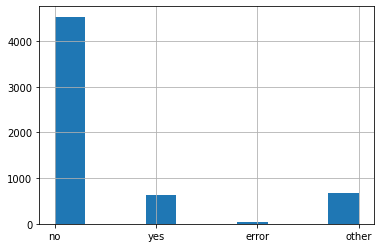

In [ ]:
train_df['OUTPUT:result'].hist()

In [ ]:
train_df['OUTPUT:result'] = train_df['OUTPUT:result'].map(dict(yes=1, no=0, other=2, error=2)).astype(int)

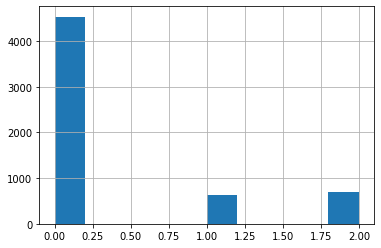

In [ ]:
train_df['OUTPUT:result'].hist()

In [ ]:
# train_image_paths = train_df.img_path.values
# train_labels = train_df.label.values


train_image_paths = train_df['INPUT:image'].values
train_labels = train_df['OUTPUT:result'].values

In [ ]:
len(train_image_paths)

5857

In [ ]:
ipyplot.plot_class_tabs(train_image_paths, train_labels, max_imgs_per_tab = 10)

# Prepare model

In [ ]:
train_dataset = ImagesDataset(train_image_paths, train_labels, transform=transform)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=params.BATCH_SIZE,
                                           num_workers=16,
                                           shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!wandb login

wandb: Currently logged in as: v_philipenko (neuro-ml). Use `wandb login --relogin` to force relogin


In [ ]:
from pytorch_lightning.loggers import WandbLogger

In [ ]:
# Run macos_cert_fix.py if you are getting ssl errors
import torch
model = ImageClassifier(learning_rate=params.LEARNING_RATE, class_weight=torch.tensor([1.0, 4.0, 1.0], device='cuda'))

In [ ]:
import wandb

In [ ]:
logger = WandbLogger(project='car_numbers', name='model_5857')


trainer = pl.Trainer(
    logger=logger,
    max_epochs=params.MAX_EPOCHS,
    log_every_n_steps=1, # Change to enable tensorboard logging
    gpus=1, # Uncomment to use GPU training
)
trainer.fit(model, train_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:353: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightnin

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
trainer.logger.log_dir

'tb_logs/init_model_2000/version_8'

In [ ]:
!ls tb_logs/init_model_2000/version_7

checkpoints  hparams.yaml


In [ ]:
trainer.logged_metrics

{'loss': tensor(0.0019)}

# Compute training set accuracy

In [37]:
labels, predictions, idxs = evaluate_model(model, train_dataset)

  0%|          | 0/184 [00:00<?, ?it/s]

In [39]:
ipyplot.plot_class_tabs(train_image_paths[idxs], predictions,)

In [40]:
predictions = [0 if x == 2 else x for x in predictions ]
labels = [0 if x == 2 else x for x in labels ]

In [41]:
f1_score(labels, predictions, labels=1, average='binary')

0.952076677316294

![image.png](attachment:3ad7e37c-019b-471c-96e7-1ccd8cd0d7ef.png)

## Evaluate on val


In [48]:
import os

full_image_paths = []

dataset_dir = 'dataset_students/classification/train_unlabelled'

for file in os.listdir(dataset_dir):
    if file.endswith(".png"):
        full_image_paths += [os.path.join(dataset_dir, file)]


len(full_image_paths)

2638

In [45]:
import numpy as np
other_part_path = np.array(list(set(full_image_paths) - set(train_image_paths)))

len(other_part_path)

2814

In [ ]:
other_part_dataset = ImagesDataset(other_part_path, transform=transform)

labels, predictions, probas, idxs = evaluate_model(model, other_part_dataset)

  0%|          | 0/204 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame(dict(idxs=idxs, file_path = other_part_path[idxs], probas=probas, predictions=predictions))

df.head(10)

,idxs,file_path,probas,predictions
0,tensor(0),dataset_students/classification/train_unlabell...,"[tensor(0.0190), tensor(0.9792), tensor(0.0018)]",1
1,tensor(1),dataset_students/classification/train_unlabell...,"[tensor(0.9997), tensor(0.0003), tensor(2.0569...",0
2,tensor(2),dataset_students/classification/train_unlabell...,"[tensor(1.0000), tensor(1.9524e-06), tensor(9....",0
3,tensor(3),dataset_students/classification/train_unlabell...,"[tensor(0.8721), tensor(2.6210e-06), tensor(0....",0
4,tensor(4),dataset_students/classification/train_unlabell...,"[tensor(0.0430), tensor(0.9570), tensor(2.2035...",1
5,tensor(5),dataset_students/classification/train_unlabell...,"[tensor(0.9819), tensor(0.0178), tensor(0.0002)]",0
6,tensor(6),dataset_students/classification/train_unlabell...,"[tensor(0.9372), tensor(0.0623), tensor(0.0005)]",0
7,tensor(7),dataset_students/classification/train_unlabell...,"[tensor(0.9995), tensor(0.0005), tensor(7.9354...",0
8,tensor(8),dataset_students/classification/train_unlabell...,"[tensor(1.0000), tensor(1.1067e-07), tensor(3....",0
9,tensor(9),dataset_students/classification/train_unlabell...,"[tensor(0.6901), tensor(0.0021), tensor(0.3078)]",0


In [ ]:
df['max_prob'] = df.probas.apply(lambda x: x.max())

In [ ]:
df.sort_values(by='max_prob').head(3700).to_csv('most_unconfident.csv') # сортим так, чтобы разметить 3700 объектов в которых мы менее всего уверны

# Evaluate on public test

In [ ]:
!wget https://tlk.s3.yandex.net/course/shad_cv_project_22/val.zip
!unzip val.zip

In [50]:
import os

val_paths = []

dataset_dir = 'val'

for file in os.listdir(dataset_dir):
    if file.endswith(".png"):
        val_paths += [os.path.join(dataset_dir, file)]


len(val_paths)

2638

In [51]:
val_dataset = ImagesDataset(val_paths, transform=transform)

labels, predictions, idxs = evaluate_model(model, val_dataset)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/83 [00:00<?, ?it/s]

In [67]:
predictions = list(map(lambda x: int(x == 1), predictions))

In [72]:
public = pd.DataFrame(dict(img_path=[x.split('/')[-1] for x in val_paths], label=predictions))

In [76]:
public.to_csv('public.csv', sep=',', index=False)

# Save model

In [42]:
trainer.save_checkpoint("model.ckpt")